In [2]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
sns.set()

In [3]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')

# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set


In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary

site_dict = pd.read_pickle("site_dic.pkl")

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])


Websites total: 48371


In [5]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]


In [6]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [7]:
from sklearn.model_selection import train_test_split
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8):
#     # Split the data into the training and validation sets
#     idx = int(round(X.shape[0] * ratio))
#     # Classifier training
#     lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
#     # Prediction for validation set
#     y_pred = lr.predict_proba(X[idx:, :])[:, 1]
#     # Calculate the quality
#     score = roc_auc_score(y[idx:], y_pred)
    x1_train, x1_test, y1_train, y1_test = train_test_split(X,y, random_state = 17, test_size = 0.1)
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(x1_train, y1_train)
   # Prediction for validation set
    y1_pred = lr.predict_proba(x1_test)[:, 1]
    # Calculate the quality
    score1 = roc_auc_score(y1_test, y1_pred)
    
    x2_train, x2_test, y2_train, y2_test = train_test_split(X,y, random_state = 0, test_size = 0.2)
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(x2_train, y2_train)
   # Prediction for validation set
    y2_pred = lr.predict_proba(x2_test)[:, 1]
    # Calculate the quality
    score2 = roc_auc_score(y2_test, y2_pred)
    
    x3_train, x3_test, y3_train, y3_test = train_test_split(X,y, random_state = 50, test_size = 0.3)
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(x3_train, y3_train)
    
   # Prediction for validation set
    y3_pred = lr.predict_proba(x3_test)[:, 1]
    # Calculate the quality
    score3 = roc_auc_score(y3_test, y3_pred)
    
    return np.mean([score1, score2, score3])

In [8]:
from sklearn.svm import SVC
def get_auc_svm_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    clf = SVC(C=C, probability = True).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = clf.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [9]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [10]:
# Feature 1 Start Month
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')
# Feature 2 start hour
start_hour = pd.DataFrame(index = full_df.index)
start_hour["st_hour"] = full_df[times].time1.apply(lambda x: x.hour)
full_new_feat["st_hour"] = start_hour["st_hour"]

# Featur 4 week day
full_new_feat["weekday"] = full_df.time1.apply(lambda x: x.weekday())

# #feature5: time spent on first 3 websites
# full_new_feat["time_3s"] = (full_df["time3"] - full_df["time1"])/np.timedelta64(1,"s")

#feature6 duration 
full_new_feat["duration"] = (full_df["time10"] - full_df["time1"])/(np.timedelta64(1,"s"))

# Feature 7 is evening  0.9691399286987523 to 0.9809647467018343
def isevening(x):
    if (x>=16)&(x<=20):return 1
    else: return 0
full_new_feat["is_evening"] = full_new_feat["st_hour"].apply(isevening)

# Feature 3 is morning finetuning 0.9809647467018343 to 0.9809647467018343
def ismorning(x):
    if (x>=7)&(x<=11):return 1
    else: return 0
full_new_feat["is_morning"] = full_new_feat["st_hour"].apply(ismorning)

# Feature 8 is_odd hour 0.9809647467018343 to 0.9809659543787952
def isoddhour(x):
    if ((x>20)&(x<7)):return 1
    else: return 0
full_new_feat["is_oddhour"] = full_new_feat["st_hour"].apply(isoddhour)

# Feature 8 is_odd hour 0.9809659543787952 to 0.9811377464264839
def midday(x):
    if (x>12)&(x<15):return 1
    else: return 0
full_new_feat["is_oddhour"] = full_new_feat["st_hour"].apply(isoddhour)

# Feature 9 day of month  0.9811377464264839 to 0.9814706123888334
full_new_feat["day"] = full_df["time1"].apply(lambda x:x.day)

# Feature 10 year 0.9814706123888334 to 0.9816203643319856
full_new_feat["year"] = full_df["time1"].apply(lambda x:x.year)

In [28]:
# Feature 11 get top 10 websites visited by Alice. count the number of those website visits in each session
#  0.9816203643319856 to 0.9815278260848561
df_alice = train_df[sites][train_df.target==1]
top_sites = pd.Series(df_alice.values.flatten()).value_counts().sort_values(ascending = False)[:5000]
top_sites_text = sites_dict.loc[top_sites.index]

df_others = train_df[sites][train_df.target==0]
top_sites_others = pd.Series(df_others.values.flatten()).value_counts().sort_values(ascending = False)[:5000]
top_sites_others_text = sites_dict.loc[top_sites_others.index]
# top_site_count = []
# for column in full_df[sites].iterrows():
    
#     list_row = (list(column[1]))
#     counter = 0
#     for site in list_row:
#         if site in top_sites.index:
#             counter = counter+1
#     top_site_count.append(counter)

# full_new_feat["top_site_count"] = pd.Series(top_site_count)  
# full_new_feat["top_site_count"] = full_new_feat["top_site_count"] * full_new_feat["duration"]
#full_new_feat.drop(["top_site_count"], axis = 1, inplace = True)

C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [12]:
# # Feature 11 time spent on 
# #0.9816203643319856 to
# # def issames2(x):
# #     if x==0: return 1
# #     else: return 0
# # #full_new_feat["morn_dur"] = full_new_feat["duration"]*full_new_feat["is_morning"]
# full_new_feat.drop(["temp" ], axis = 1, inplace = True)
# # full_new_feat["stdur"] = (full_new_feat["1stdur"] - full_new_feat["2nddur"])/full_new_feat["duration"]

In [13]:
# #Feature 11 add all useful time_diff 0.981707618992411 to 0.9819529283750947
# temp_feat = pd.DataFrame(index = full_new_feat.index)
# score_time_diff = []
# for i in range(0,10):
#     for j in range(0,10):
#         if j>i:
#             full_new_feat["temp"] = (full_df[times].iloc[:,j] - full_df[times].iloc[:,i])/np.timedelta64(1,"s")
#             score_C_1 = test_score()
#             print(j, i, score_C_1)
#             score_time_diff.append(score_C_1)
#             temp_feat["time"+str(j)+"-"+"time"+str(i)] = full_new_feat["temp"]

# pd.to_pickle(temp_feat, "score_time_diff_all2.pkl")
# # ree = pd.read_pickle("score_time_diff2.pkl")
# with open("time_diff_score2.txt", "w") as file:
#     for score in score_time_diff:
#         file.write(str(score))

# temp_feat = pd.read_pickle("score_time_diff_all2.pkl")
# score_time_diff_file = open("time_diff_score2.txt")
# text = score_time_diff_file.read()
# score_time_diff = ["0."+i for i in text.split(".")[1:]]

# for i, score in enumerate(score_time_diff):
#      if float(score)>0.9247:
#         full_new_feat["time_diff"+str(i)] = temp_feat.iloc[:,i]

# time_diff_list = []
# for column in full_new_feat.columns:
#     if column[:9]=="time_diff":
#         time_diff_list.append(column)

# full_new_feat["time_diff"] = full_new_feat[time_diff_list[0]]
# for c in range(1, len(time_diff_list)):
#     full_new_feat["time_diff"] = full_new_feat["time_diff"] * full_new_feat[time_diff_list[c]]
# full_new_feat.drop(time_diff_list, axis = 1, inplace = True)        
# max(score_time_diff)    

In [14]:
# #feature 12 days from first session 0.9819529283750947 to 0.982222693216237
# day1 = full_df.time1.iloc[0]
# days_ser = full_df["time1"] - day1

# full_new_feat["days_till"] = days_ser.apply(lambda x: np.log1p(x.days))

# #feature 13 days from first session no log 0.982222693216237 to 0.9823316860619586
# day1 = full_df.time1.iloc[0]
# days_ser = full_df["time1"] - day1

# full_new_feat["days_till_nolog"] = days_ser.apply(lambda x: x.days)

In [18]:
#feature 13 number of unque websites in each session
# full_new_feat["unique_sites"] = [full_df[sites].iloc[i,:].nunique() for i in range(0,full_df.shape[0])]
# full_new_feat["unique_sites"] = full_df[sites].nunique(axis = 1)
full_new_feat["dur_per_unique_sites"] = full_new_feat["duration2"]/full_df[sites].nunique(axis = 1)

In [19]:
# first site == alice most frequent first site 1
# first site in alice top first site list?
# first site == others most frequent site 1
# first site in others top first site list?
# similarly for the last site

In [20]:
# is first site in alice fav?
alice_site1_fav = train_df[train_df["target"]==1].site1.value_counts()[:10].values
# for content in alice_site1_fav:
#     full_new_feat["is_site1_"+str(content)] = (full_df["site1"]==content).astype("int")
def isalicefav(site):
    if site in alice_site1_fav: return 1
    else: return 0
full_new_feat["is_site1_alice"] = full_df["site1"].apply(isalicefav)
# is_site_list= []
# for column in full_new_feat.columns:
#     if column[:7]=="is_site":
#         is_site_list.append(column)
# full_new_feat.drop(is_site_list, axis = 1, inplace = True)

In [21]:
full_new_feat["is_site2_alice"] = full_df["site2"].apply(isalicefav)

In [281]:
# full_new_feat["is_site1and2_alice"] = full_new_feat["is_site1_alice"] & full_new_feat["is_site2_alice"]

In [268]:
# # is first site in others fav?
# others_site1_fav = train_df[train_df["target"]==0].site1.value_counts()[:10].values
# # for content in alice_site1_fav:
# #     full_new_feat["is_site1_"+str(content)] = (full_df["site1"]==content).astype("int")
# def isothersfav(site):
#     if site in others_site1_fav: return 1
#     else: return 0
# full_new_feat["is_site1_others"] = full_df["site1"].apply(isothersfav)

In [ ]:
# full_new_feat["is_site10_others"] = full_df["site10"].apply(isothersfav)

In [346]:
# number of sites in alice top 10 sites per session
# alice_top_10 = top_sites[:5].index
# def count_alice_list(session):
#     cnt = 0
#     for item in session:
#         if item in alice_top_10:
#             cnt+=1
#     return cnt

# count = []
# for i in range(0,full_df.shape[0]):
#     if i%1000==0:print(i)
#     session = full_df[sites].iloc[i,:]
#     count.append(count_alice_list(session))
# full_new_feat["alice_count"] = count

In [299]:
# full_new_feat['is_weekend'] = full_df['time1'].apply(lambda ts: 1 if ts.date().weekday() in (5, 6) else 0)
# full_new_feat['work_hours'] = full_df['time1'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) &
#                                              ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0)

In [304]:
# facebook_ids = []
# youtube_ids = []

# for key in list(site_dict.keys()):
#     if 'facebook' in key:
#         facebook_ids.append(site_dict[key])
#     if 'youtube' in key:
#         youtube_ids.append(site_dict[key])
# print(youtube_ids)

[38132, 41285, 80, 38133, 15317, 656, 16672, 874, 6581, 38134, 24557, 1307, 12597, 76, 14774, 1345, 74, 16606, 28062, 2329, 1056, 676, 2574, 13347]


In [17]:
#feature6 duration 
full_new_feat["duration2"] = (full_df[times].max(axis=1) - full_df[times].min(axis=1))/(np.timedelta64(1,"s"))

In [25]:
#full_new_feat.drop(time_diff_list, axis = 1, inplace = True)
full_new_feat.fillna(value = 1, inplace = True)
categorical = ["weekday", "year", "start_month", "st_hour"]
enc = OneHotEncoder()
cat = full_new_feat[categorical]
cat_ohe2 = enc.fit_transform(cat)
full_new_feat.drop(categorical, axis = 1, inplace=True)

In [22]:

#feature mean duration of alice +_variance
df_alice = train_df[train_df.target==1]
df_alice["duration"] = (df_alice[times].max(axis=1) - df_alice[times].min(axis=1))/(np.timedelta64(1,"s"))
mean_alice = df_alice["duration"].mean()
var_alice = df_alice["duration"].var()
print(mean_alice, var_alice )
# full_new_feat["duration"] = (full_df["time10"] - full_df["time1"])/(np.timedelta64(1,"s"))

52.29647366129734 23503.653789824257


C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [369]:

#feature mean duration of alice +_variance
df_others = train_df[train_df.target==0]
df_others["duration"] = (df_others[times].max(axis=1) - df_others[times].min(axis=1))/(np.timedelta64(1,"s"))
mean_others = df_others["duration"].mean()
var_others = df_others["duration"].var()
print(mean_others, var_others )
# full_new_feat["duration"] = (full_df["time10"] - full_df["time1"])/(np.timedelta64(1,"s"))

139.28237232552215 88003.30957476175


C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
full_new_feat["duration_alicemean"] = (full_new_feat["duration2"]<52).astype(int)
# full_new_feat["duration_otherrsmean"] = (full_new_feat["duration2"]>139).astype(int)

In [38]:
cat_ohe = cat_ohe2

In [377]:
def weekn(day):
    if day<8: return 1
    elif day<15: return 2
    elif day<22: return 3
    else: return 4
        
full_new_feat["week_n"] = full_new_feat["day"].apply(weekn)

In [26]:
# full_new_feat.alice_count.to_csv("alice_top_count_per_session.txt")

# # ttmp = pd.DataFrame(index = full_new_feat.index)
# # ttmp['is_oddhour'] = full_new_feat['is_oddhour']
# full_new_feat.drop(['duration_otherrsmean'], axis=1, inplace = True)
# full_new_feat['is_oddhour'] = ttmp['is_oddhour']
full_new_feat.head()

,duration,is_evening,is_morning,is_oddhour,day,duration2,dur_per_unique_sites,is_site1_alice,is_site2_alice,duration_alicemean
session_id,,,,,,,,,,
21669,1.0,0,1,0,12,0.0,0.000000,1,0,1
54843,1.0,0,1,0,12,1786.0,595.333333,1,0,0
77292,4.0,0,1,0,12,4.0,0.666667,0,0,1
114021,3.0,0,1,0,12,3.0,0.600000,0,0,1
146670,2.0,0,1,0,12,2.0,0.333333,0,0,1


### Test

In [43]:
# Prepare the training and test data 0.91389414 to 0.914845162113809(text_alice500) to 0.9164647800531288(+text_others500)
#to 0.916634624667843 (ngrams 10) to 0.9192356342949559(top 2000) to 0.9192514134362624(top 5000) to 0.9229160384203
#(time to ohe) to 0.9230412784076141 (dropped log days_till) to 0.9246250276884662 (dropped days_till) to 0.9248947169516262
#(tuned time_diff) to 0.9249496387913366  (dur/unique sites) to 0.9250447714632752(first site alice fav?) to 0.9250687411582044
# (second site alice fav?) to 0.9251497545164666(alice fav count session) to 0.9253129438676316(duration corrected) to 
# 0.92532132(durpeuniq updated) to 0.92537690(dur_alice_mean)
def test_score():
    
    full_new_feat.fillna(0, inplace = True)
    tmp_scaled = StandardScaler().fit_transform(full_new_feat)

    X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],tmp_scaled[:idx_split,:], cat_ohe[:idx_split,:],
                                 X_train_text[:idx_split,:], X_train_others_text[:idx_split,:]]))
    #cross_validation with time-series split 
    from sklearn.model_selection import TimeSeriesSplit, cross_val_score
    time_split = TimeSeriesSplit(n_splits = 10)
    lr = LogisticRegression(C=1, random_state = 17, solver = "liblinear")
    cv_scores = cross_val_score(lr, X_train, y_train, scoring = "roc_auc", cv = time_split)
    return cv_scores.mean()
sc = test_score()
sc

0.9247750317179511

In [142]:
from sklearn.model_selection import GridSearchCV
param = np.logspace(-2, 2, 10)
clf = SVC(verbose = 1)
svc_grid = GridSearchCV(estimator = clf, param_grid = {"C":param}, scoring = "roc_auc", cv = time_split, verbose = 1)
svc_grid.fit(X_train, y_train)
C = svc_grid.best_params_
pickle.dump(svc_grid, open("svc_grid_timesplit3.pkl", "wb"))

In [148]:
from sklearn.externals import joblib
lr_grid = joblib.load("lr_grid_timesplit3.pkl")
print(param)
lr_grid.best_params_

[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]


{'C': 1.6681005372000592}

In [ ]:

print(param)
lr_grid.cv_results_["mean_test_score"]

In [152]:
C = C["C"]
C

1.6681005372000592

In [386]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], cat_ohe[:idx_split,:], tmp_scaled[:idx_split,:],
                             X_train_text[:idx_split,:], X_train_others_text[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], cat_ohe[idx_split:,:], tmp_scaled[idx_split:,:],
                            X_test_text[:idx_split,:], X_test_others_text[:idx_split,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)
# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'freeride_1004.csv')

### SVM

In [ ]:
from sklearn.svm import SVC
full_new_feat.fillna(0, inplace = True)
tmp_scaled = StandardScaler().fit_transform(full_new_feat)

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],tmp_scaled[:idx_split,:], cat_ohe[:idx_split,:],
                             X_train_text[:idx_split,:], X_train_others_text[:idx_split,:]]))
#cross_validation with time-series split 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
time_split = TimeSeriesSplit(n_splits = 10)
clf = SVC(verbose = 1)
cv_scores = cross_val_score(clf, X_train, y_train, scoring = "roc_auc", cv = time_split, verbose = 1)
return cv_scores.mean()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [322]:
cv_scores.mean()

0.8730534190773087

### Tune LR

In [333]:
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

scores = []
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

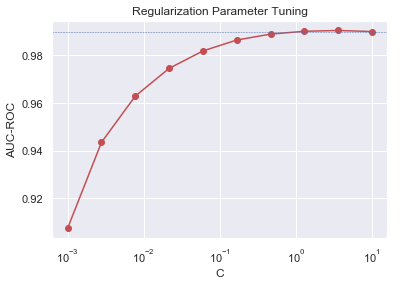

3.593813663804626
0.9903723885510597


In [334]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

index = (scores.index(max(scores)))
C = Cs[index]
print(C)
print(max(scores))

In [50]:
0.1668100537200059
0.9876519559536059

[0.8498513349661125,
 0.9272669002313909,
 0.9619134916839365,
 0.9723371024931283,
 0.9743525643812588,
 0.9734314087793284,
 0.9712674026250067,
 0.9681967329922854,
 0.9636785115622992,
 0.9576882828765899]

In [51]:
Cs

array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])

### COUNT VECTORIZER

In [27]:
df_cv_train = train_df[sites]
df_cv_test = test_df[sites]

In [28]:
sites_dic = pd.read_pickle("site_dic.pkl")
sites2 = {value: key for key, value in sites_dic.items()}


In [29]:
for column in df_cv_train[sites].columns:
    df_cv_train[column] = df_cv_train[column].map(sites2)
df_cv_train = df_cv_train.fillna("missing")

C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
for column in df_cv_test[sites].columns:
    df_cv_test[column] = df_cv_test[column].map(sites2)
df_cv_test = df_cv_test.fillna("missing")

C:\Users\sreej\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
df_cv_train.to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
df_cv_test.to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

In [40]:
top_list = list(top_sites_text.values.flatten())
top_list = [i for i in top_list if str(i)!="nan"]
cv = TfidfVectorizer(stop_words=[], ngram_range=(1, 10), max_features=30000, analyzer = "word").fit(list(top_list))

# cvt = TfidfVectorizer(stop_words=["www", "com"]).fit(alice_top20)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_text = cv.transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:    
    X_test_text = cv.transform(inp_test_file)
X_train_text.shape, X_test_text.shape

((253561, 4856), (82797, 4856))

In [41]:
top_list_others = list(top_sites_others_text.values.flatten())
top_list_others = [i for i in top_list_others if str(i)!="nan"]
cv2 = TfidfVectorizer(ngram_range=(1, 10), max_features=30000).fit(list(top_list_others))

# cvt = TfidfVectorizer(stop_words=["www", "com"]).fit(alice_top20)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_others_text = cv2.transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_others_text = cv2.transform(inp_test_file)
X_train_others_text.shape, X_test_others_text.shape

((253561, 20527), (82797, 20527))

In [36]:
cv.get_feature_names()

['abba',
 'abba accenture',
 'abcompteur',
 'abmr',
 'accenture',
 'accn',
 'accn allocine',
 'account',
 'account live',
 'accounts',
 'accounts google',
 'accounts youtube',
 'acsta',
 'active',
 'active agent',
 'actu',
 'actu money',
 'adbutter',
 'adform',
 'adki',
 'admaym',
 'admin',
 'admin brightcove',
 'admin wbusiness',
 'adobe',
 'adrcntr',
 'adventori',
 'adyoulike',
 'aeriagames',
 'affiz',
 'afpa',
 'agent',
 'agora',
 'aion',
 'aion gameforge',
 'airfrance',
 'ajax',
 'ajax cloudflare',
 'ajax googleapis',
 'ajax microsoft',
 'akamai',
 'akamaihd',
 'akvideo',
 'akvideo aufeminin',
 'alephd',
 'allgoob',
 'allocine',
 'allocine disqus',
 'allsoftdll',
 'amazonaws',
 'anno',
 'anno online',
 'annonces',
 'annonces emploi',
 'annonces emploi vivastreet',
 'annuaire',
 'annuaire france',
 'apis',
 'apis google',
 'apnx',
 'apnx match',
 'apnx match dotomi',
 'appspot',
 'asset',
 'asset email',
 'asset email match',
 'assets',
 'assets amazonaws',
 'assets data',
 'assets 

In [221]:
list(top_sites_text.values.flatten())

['i1.ytimg.com',
 's.youtube.com',
 'www.youtube.com',
 'www.facebook.com',
 'www.google.fr',
 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'apis.google.com',
 's.ytimg.com',
 'r2---sn-gxo5uxg-jqbe.googlevideo.com']

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# corpus = pd.concat(df_cv[column] for column in df_cv.columns)
# vector = CountVectorizer(max_features = 3, stop_words = ["www", "com", "net", "org"])
# vector.fit(corpus)

In [ ]:
# dtm = csr_matrix((1,3))
# for row in df_cv.iterrows():
#     dtm = csr_matrix(vstack([dtm, vector.transform(list(row[1]))]))
    

In [280]:
Cs

array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])

In [335]:
C

3.593813663804626

In [336]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], cat_ohe[:idx_split,:], tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], cat_ohe[idx_split:,:], tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)
# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'freeride_7_4.csv')